now only fish/engine

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Paths
data_folder = "./time_sets_standardized"

# Function to preprocess cyclical features
def encode_cyclical(data, column):
    radians = np.deg2rad(data[column])
    data[f'{column}_sin'] = np.sin(radians)
    data[f'{column}_cos'] = np.cos(radians)
    return data

# Function to load and process individual vessel data
def load_and_process_vessel_data(folder_path):
    data, labels = [], []
    status_counts = {}

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))

            if "Heading" not in df.columns or df["Heading"].isnull().any():
                continue  # Skip files with missing or invalid data

            # Subtract initial COG from all COG and Heading values
            initial_cog = df["COG"].iloc[0]
            df["COG"] = (df["COG"] - initial_cog) % 360
            df["Heading"] = (df["Heading"] - initial_cog) % 360

            # Apply cyclical encoding to COG and Heading
            df = encode_cyclical(df, "COG")
            df = encode_cyclical(df, "Heading")

            # Extract the time series features
            sog = df["SOG"].values
            cog_sin = df["COG_sin"].values
            cog_cos = df["COG_cos"].values
            heading_sin = df["Heading_sin"].values
            heading_cos = df["Heading_cos"].values

            # Extract label
            label = df["Navigational status"].iloc[0]
            if label in ["Under way using engine", "Engaged in fishing"]:
                # Calculate statistics for each feature
                sog_mean = np.mean(sog)
                sog_min = np.min(sog)
                sog_max = np.max(sog)
                sog_std = np.std(sog)

                cog_sin_mean = np.mean(cog_sin)
                cog_cos_mean = np.mean(cog_cos)

                heading_sin_mean = np.mean(heading_sin)
                heading_cos_mean = np.mean(heading_cos)

                # Rate of change (slope) for SOG
                sog_slope = np.polyfit(range(len(sog)), sog, 1)[0]  # Linear fit slope

                # Add to the dataset
                features = [
                    sog_mean, sog_min, sog_max, sog_std, sog_slope,
                    cog_sin_mean, cog_cos_mean,
                    heading_sin_mean, heading_cos_mean
                ]

                data.append(features)
                labels.append(label)

                if label not in status_counts:
                    status_counts[label] = 0
                status_counts[label] += 1

    return np.array(data), np.array(labels), status_counts

# Load and preprocess data
data, labels, status_counts = load_and_process_vessel_data(data_folder)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Print class distribution
print("Class distribution:", dict(zip(label_encoder.classes_, np.bincount(labels))))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Apply undersampling to balance the classes
def undersample_data(X, y):
    class_0 = X[y == 0]  # Minority class (0)
    class_1 = X[y == 1]  # Majority class (1)

    class_1_undersampled = resample(class_1, replace=False, n_samples=len(class_0), random_state=42)

    X_balanced = np.vstack((class_0, class_1_undersampled))
    y_balanced = np.hstack((np.zeros(len(class_0)), np.ones(len(class_1_undersampled))))

    return X_balanced, y_balanced

X_train_balanced, y_train_balanced = undersample_data(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=64, max_value=256, step=64), activation='relu', input_dim=X_train_balanced.shape[1]))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):  # Tune the number of hidden layers
        model.add(Dense(hp.Int(f'units_{i+2}', min_value=64, max_value=256, step=64), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(2, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_tuner_dir',
    project_name='vessel_status_tuning'
)

# Run the hyperparameter search
tuner.search(X_train_balanced, y_train_balanced, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Retrieve the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Units in first layer: {best_hps.get('units_1')}")
print(f"Dropout in first layer: {best_hps.get('dropout_1')}")
print(f"Number of layers: {best_hps.get('num_layers')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_balanced, y_train_balanced, validation_data=(X_test, y_test), epochs=100, batch_size=32)

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


Trial 90 Complete [00h 00m 58s]
val_accuracy: 0.8105050325393677

Best val_accuracy So Far: 0.8105050325393677
Total elapsed time: 00h 19m 35s
Best Hyperparameters:
Units in first layer: 64
Dropout in first layer: 0.2
Number of layers: 2
Learning rate: 0.003927381978059904
Epoch 1/100
220/220 [==============================] - 2s 6ms/step - loss: 0.5022 - accuracy: 0.7472 - val_loss: 0.4669 - val_accuracy: 0.7661
Epoch 2/100
220/220 [==============================] - 1s 6ms/step - loss: 0.4646 - accuracy: 0.7756 - val_loss: 0.4762 - val_accuracy: 0.7580
Epoch 3/100
220/220 [==============================] - 1s 5ms/step - loss: 0.4528 - accuracy: 0.7850 - val_loss: 0.4819 - val_accuracy: 0.7527
Epoch 4/100
220/220 [==============================] - 1s 5ms/step - loss: 0.4535 - accuracy: 0.7874 - val_loss: 0.4318 - val_accuracy: 0.7846
Epoch 5/100
220/220 [==============================] - 1s 5ms/step - loss: 0.4442 - accuracy: 0.7894 - val_loss: 0.4381 - val_accuracy: 0.7786
Epoch 6/100

 trains the best model from Keras Tuner for a specified number of epochs and generates comprehensive visualizations

Epoch 1/100
220/220 [==============================] - 2s 7ms/step - loss: 0.5029 - accuracy: 0.7436 - val_loss: 0.4485 - val_accuracy: 0.7745
Epoch 2/100
220/220 [==============================] - 1s 5ms/step - loss: 0.4683 - accuracy: 0.7732 - val_loss: 0.4509 - val_accuracy: 0.7745
Epoch 3/100
220/220 [==============================] - 1s 5ms/step - loss: 0.4529 - accuracy: 0.7823 - val_loss: 0.4234 - val_accuracy: 0.7867
Epoch 4/100
220/220 [==============================] - 1s 5ms/step - loss: 0.4456 - accuracy: 0.7870 - val_loss: 0.4304 - val_accuracy: 0.7798
Epoch 5/100
220/220 [==============================] - 1s 5ms/step - loss: 0.4443 - accuracy: 0.7898 - val_loss: 0.4371 - val_accuracy: 0.7838
Epoch 6/100
220/220 [==============================] - 1s 5ms/step - loss: 0.4399 - accuracy: 0.7900 - val_loss: 0.4419 - val_accuracy: 0.7798
Epoch 7/100
220/220 [==============================] - 1s 5ms/step - loss: 0.4385 - accuracy: 0.7962 - val_loss: 0.4383 - val_accuracy: 0.7871

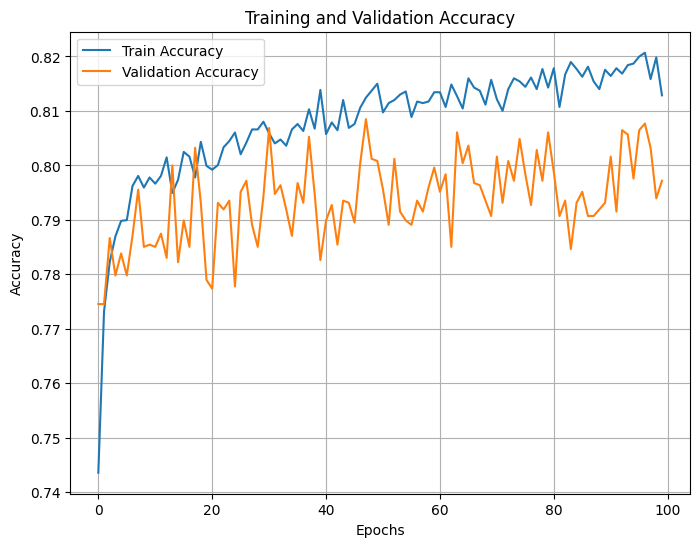

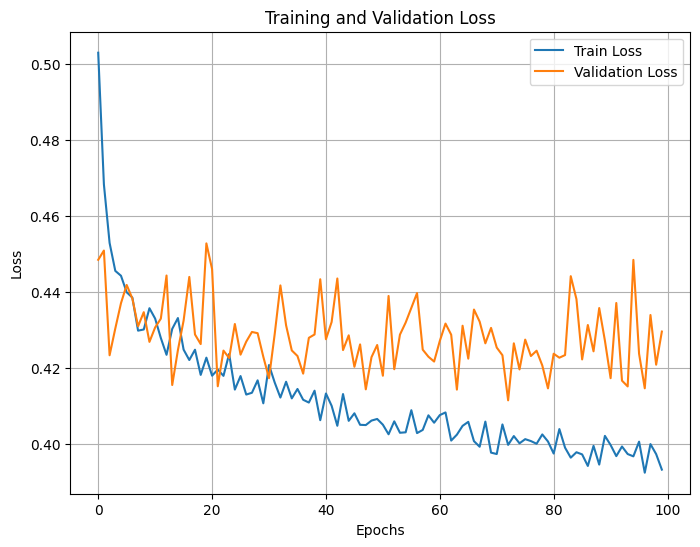

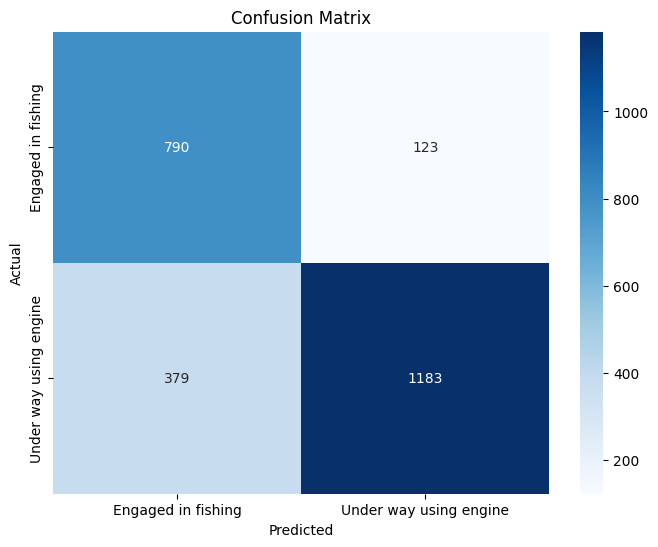

Classification Report:
                        precision    recall  f1-score   support

    Engaged in fishing       0.68      0.87      0.76       913
Under way using engine       0.91      0.76      0.82      1562

              accuracy                           0.80      2475
             macro avg       0.79      0.81      0.79      2475
          weighted avg       0.82      0.80      0.80      2475



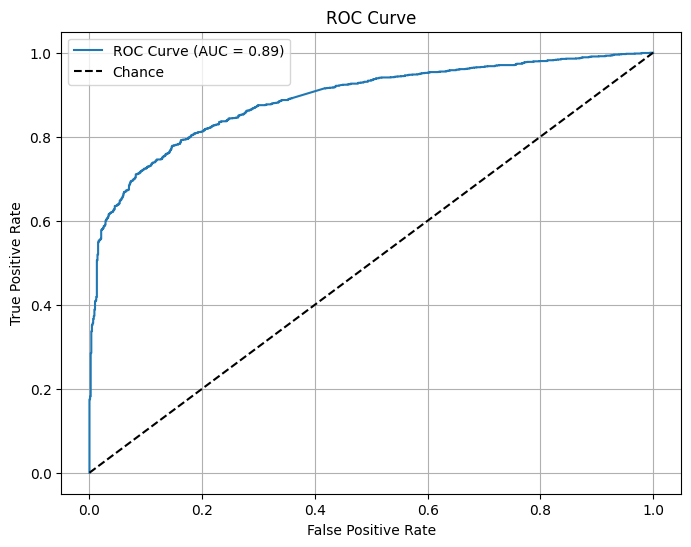

Weighted F1 Score: 0.8006


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np

# Train the best model with the specified number of epochs
specified_epochs = 100  # Adjust this as needed
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_test, y_test),
    epochs=specified_epochs,
    batch_size=32,
    verbose=1
)

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
y_pred_prob = best_model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Predicted classes

# 1. Learning Curves
def plot_learning_curves(history):
    # Separate Accuracy and Loss plots
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(history)

# 2. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

class_names = label_encoder.classes_
plot_confusion_matrix(y_test, y_pred, class_names)

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 4. ROC Curve
def plot_roc_curve(y_true, y_pred_prob, class_names):
    # For binary classification, use probabilities of the positive class
    if len(class_names) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Chance")
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        # Multiclass ROC Curve
        y_test_binarized = label_binarize(y_true, classes=range(len(class_names)))
        fpr, tpr, roc_auc = {}, {}, {}
        
        plt.figure(figsize=(10, 8))
        for i in range(len(class_names)):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Chance")
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.show()

plot_roc_curve(y_test, y_pred_prob, class_names)

# 5. F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")


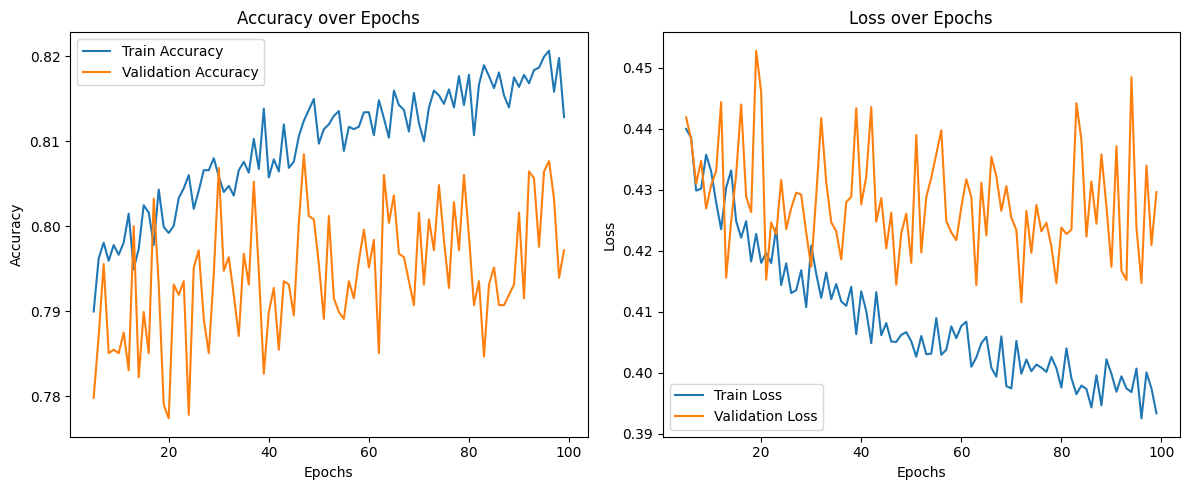

In [3]:
import matplotlib.pyplot as plt

def plot_learning_curve(history, epochs_to_skip=5):
    plt.figure(figsize=(12, 5))

    # Slice history to skip the first 'epochs_to_skip' epochs
    history_epochs = range(epochs_to_skip, len(history.history['accuracy']))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_epochs, history.history['accuracy'][epochs_to_skip:], label='Train Accuracy')
    plt.plot(history_epochs, history.history['val_accuracy'][epochs_to_skip:], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history_epochs, history.history['loss'][epochs_to_skip:], label='Train Loss')
    plt.plot(history_epochs, history.history['val_loss'][epochs_to_skip:], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)



78/78 [==============================] - 0s 2ms/step


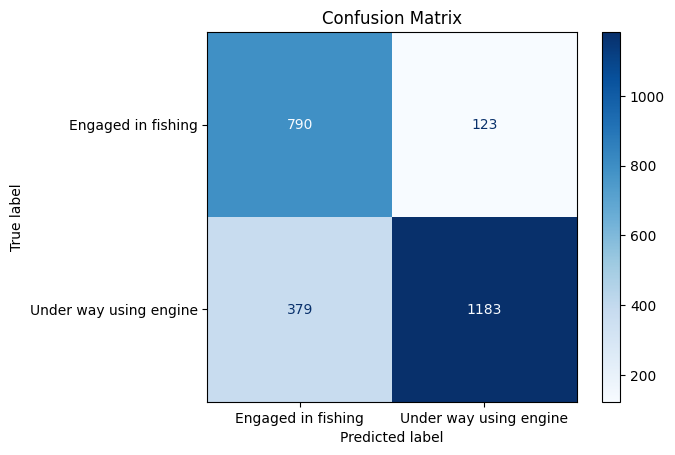

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions on the test data
y_pred = best_model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)  # Convert to class labels (0 or 1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [5]:
from sklearn.metrics import classification_report

# Print precision, recall, and F1-score
report = classification_report(y_test, y_pred_class, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)


Classification Report:
                        precision    recall  f1-score   support

    Engaged in fishing       0.64      0.93      0.76       913
Under way using engine       0.94      0.69      0.80      1562

              accuracy                           0.78      2475
             macro avg       0.79      0.81      0.78      2475
          weighted avg       0.83      0.78      0.78      2475



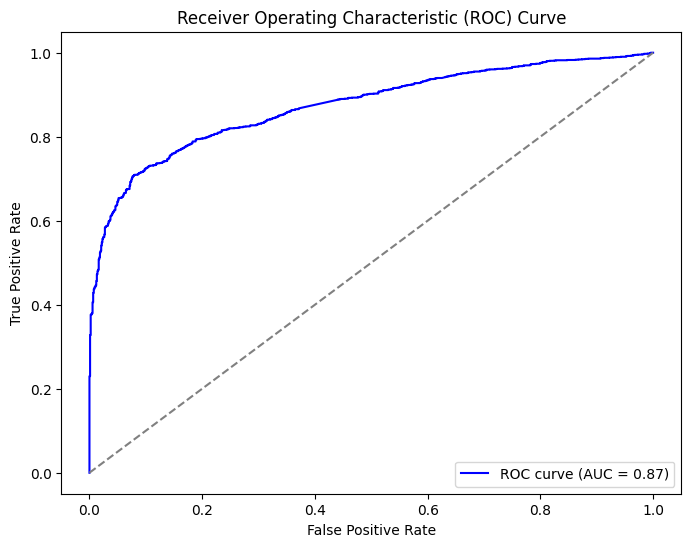

In [6]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])  # Using class 1 for positive class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal (random classifier)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
